In [388]:
import os
import numpy as np
from itertools import islice

path = './sims/output/'
extension = '.mco'
dirs = [e.name for e in os.scandir(path)]

wls = np.arange(740, 902, 2)
bin_size = 0.05
dists = np.arange(99)*bin_size
reflectance_lines = 99 # ignore the overflow bin
reflectance_col_header = "Rd_r #Rd[0], [1],..Rd[nr-1]. [1/cm2]\n"

def read_reflectance_data(folder):
    file_names = [folder + '_' + str(e) for e in range(len(wls))]

    result = np.zeros((len(wls), len(dists)))

    for i in range(len(wls)):
        with open(path + folder + '/' + file_names[i] + extension) as lines:
            read_file = lines.readlines()
            col_i = read_file.index(reflectance_col_header)
            result[i, :] = np.genfromtxt(read_file[col_i+1:col_i+reflectance_lines+1])
    
    return result

reflectances = {}
for dir in dirs:
    reflectances[dir] = read_reflectance_data(dir)

In [389]:
len(reflectances)

327

distance 1.0 being plotted


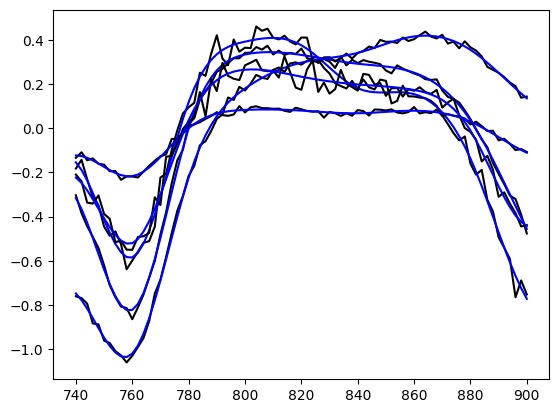

In [400]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline

degree = 3
n_knots = 9
knots = np.r_[[min(wls)]*3, np.linspace(min(wls), max(wls), n_knots), [max(wls)]*3]

dist_i_one = 20
dist_i_two = 70
print(f'distance {dist_i_one*bin_size} being plotted')

def transform_data(y):
    y_prime = np.log(y)
    y_prime = y_prime - np.mean(y_prime)
    return y_prime

plt.figure()
for key, e in islice(reflectances.items(), 5):
    y = transform_data(e[:, dist_i_two])
    spline = make_lsq_spline(wls, y, t=knots)
    
    plt.plot(wls, y, color='black')
    plt.plot(wls, spline(wls), color='blue')

plt.show()

In [401]:
print(f'generating summary statistics with distances {dist_i_one*bin_size} and {dist_i_two*bin_size}')

summary_statistics = {k: {} for k in dirs}
for key, e in reflectances.items():
    ys = [e[:, dist] for dist in [dist_i_one, dist_i_two]]
    y_primes = [transform_data(y) for y in ys]
    suffixes = ['one', 'two']

    splines = [make_lsq_spline(wls, y, t=knots) for y in ys]

    # spline coeffs for fits to y_prime
    for suffix, y in zip(suffixes, splines):
        summary_statistics[key]['spline_c_' + suffix] = y.c
    
    # log(mean) of y
    for suffix, y in zip(suffixes, [np.log(np.mean(y)) for y in ys]):
        summary_statistics[key]['log_mean_' + suffix] = y
    
    # log(variance) of y_prime
    for suffix, y in zip(suffixes, y_primes):
        summary_statistics[key]['variance_' + suffix] = np.log(np.var(y))

generating summary statistics with distances 1.0 and 3.5


In [402]:
import pandas as pd

def build_summary_stat_x(uuid):
    summary = summary_statistics[uuid]
    summary_stats = [np.atleast_1d(summary[key + '_' + suffix]) for key in ['spline_c', 'variance', 'log_mean'] for suffix in suffixes]
    return np.concatenate(summary_stats)

df = pd.read_csv('./sims/df.csv', index_col=0)
target_col = 'height_csf'
df = df[[target_col, 'uuid']]

df = df[df.loc[:, 'uuid'].apply(lambda uuid: uuid in reflectances)]
df.loc[:, 'x'] = df.loc[:, 'uuid'].apply(build_summary_stat_x)

def abc(df):
    y = np.zeros(len(df))
    mat = np.zeros((len(df), len(df['x'].iloc[0])))

    for i, (_, row) in enumerate(df.iterrows()):
        y[i] = row[target_col]
        mat[i, :] = row['x']
    
    # matrix eqn y = mat @ beta

    mat_with_const = np.concatenate([np.ones((mat.shape[0], 1)), mat], axis=1)
    beta = np.linalg.pinv(mat_with_const) @ y

    # model y as mat @ beta

    summary_stat = mat_with_const @ beta

    df.loc[:, 'summary_stat'] = df.loc[:, 'x'].apply(lambda x: np.sum(x * beta[1:] + beta[0]))

    return y, summary_stat, df

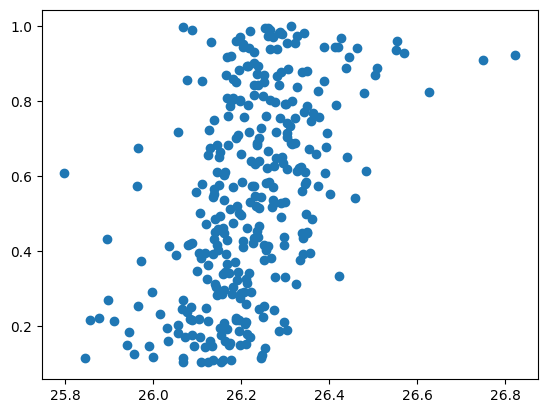

In [403]:
y, summary_stat, df = abc(df)

plt.figure()
plt.scatter(df['summary_stat'], df[target_col])
plt.show()

In [404]:
reduced_df = df.query('340 < summary_stat < 400')[['uuid', target_col, 'x']]


y, summary_stat, reduced_df = abc(reduced_df)

plt.figure()
plt.scatter(reduced_df['summary_stat'], reduced_df[target_col])
plt.show()

IndexError: single positional indexer is out-of-bounds

In [ ]:
double_reduced_df = reduced_df.query('64 < summary_stat < 64.2')[['uuid', target_col, 'x']]


y, summary_stat, _ = abc(double_reduced_df)

plt.figure()
plt.scatter(double_reduced_df['summary_stat'], double_reduced_df[target_col])
plt.show()

IndexError: single positional indexer is out-of-bounds